In [7]:
import pandas as pd 
import numpy as np
from time import time
import seaborn as sns

In [20]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC


import matplotlib.pyplot as plt
from matplotlib import pyplot

import sys
import warnings
warnings.filterwarnings("ignore")



In [3]:
# import sqlite3

# with sqlite3.connect("../laliga.sqlite") as conn:
#     df = pd.read_sql("SELECT * FROM Matches", con = conn)

# df = df.loc[-df.score.isnull()]

# def parse_score(score_as_string):
#         if score_as_string is None: 
#             return None
#         home_goals, away_goals = score_as_string.split(":")
#         home_goals = int(home_goals)
#         away_goals = int(away_goals)
#         if home_goals > away_goals: 
#             return -1
#         if away_goals > home_goals: 
#             return 1 
#         else: 
#             return 0  

# df['result'] = df['score'].apply(parse_score)
# df1 = df.copy()
# df


In [3]:
df = pd.read_csv (r'Training_ML.csv')
df.dropna(subset = ["result"], inplace=True)
df1 = df.copy()


In [4]:
df1.result.unique()
df1

,season,division,matchday,team,Away_team,W,L,T,result,GD,GD_cum,rank,last_results
0,1928-1929,1,1,Arenas Club,Athletic Madrid,0,1,0,L,-1,-1,7,['L']
1,1928-1929,1,2,Arenas Club,Catalunya,0,2,0,L,-3,-4,10,"['L', 'L']"
2,1928-1929,1,3,Arenas Club,Real Unión,0,2,1,T,0,-4,9,"['T', 'L', 'L']"
3,1928-1929,1,4,Arenas Club,Barcelona,0,2,2,T,0,-4,9,"['T', 'T', 'L', 'L']"
4,1928-1929,1,5,Arenas Club,Athletic,1,2,2,W,1,-3,6,"['W', 'T', 'T', 'L', 'L']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95994,2021-2022,2,2,UD Ibiza,Málaga CF,0,0,2,T,0,0,12,"['T', 'T']"
95995,2021-2022,2,3,UD Ibiza,CD Leganés,1,0,2,W,1,1,6,"['W', 'T', 'T']"
95996,2021-2022,2,1,UD Las Palmas,Real Valladolid,0,0,1,T,0,0,10,['T']
95997,2021-2022,2,2,UD Las Palmas,Girona,0,0,2,T,0,0,14,"['T', 'T']"


In [5]:
# convert strings in numbers 
le = preprocessing.LabelEncoder()


le.fit(pd.concat([df1.team, df1.Away_team]).drop_duplicates())

df1['team'] = le.transform(df1['team'])
df1['Away_team'] = le.transform(df1['Away_team'])

le.fit(df1['result'].drop_duplicates())
df1['result'] = le.transform(df1['result'])

df1[['team','Away_team','result']] = df1[['team','Away_team','result']].stack().rank(method='dense').unstack().astype(int)


df1  




,season,division,matchday,team,Away_team,W,L,T,result,GD,GD_cum,rank,last_results
0,1928-1929,1,1,8,13,0,1,0,1,-1,-1,7,['L']
1,1928-1929,1,2,8,57,0,2,0,1,-3,-4,10,"['L', 'L']"
2,1928-1929,1,3,8,117,0,2,1,2,0,-4,9,"['T', 'L', 'L']"
3,1928-1929,1,4,8,24,0,2,2,2,0,-4,9,"['T', 'T', 'L', 'L']"
4,1928-1929,1,5,8,12,1,2,2,3,1,-3,6,"['W', 'T', 'T', 'L', 'L']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95994,2021-2022,2,2,139,91,0,0,2,2,0,0,12,"['T', 'T']"
95995,2021-2022,2,3,139,35,1,0,2,3,1,1,6,"['W', 'T', 'T']"
95996,2021-2022,2,1,140,118,0,0,1,2,0,0,10,['T']
95997,2021-2022,2,2,140,76,0,0,2,2,0,0,14,"['T', 'T']"


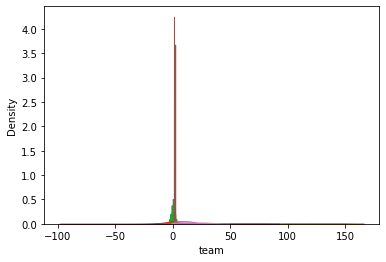

In [18]:
feature_cols = ['team','Away_team','GD','GD_cum','rank','division','matchday'] 
features = df1.loc[:,feature_cols]
target = df1.result


for col in features:
    sns.kdeplot(features[col], shade=True)

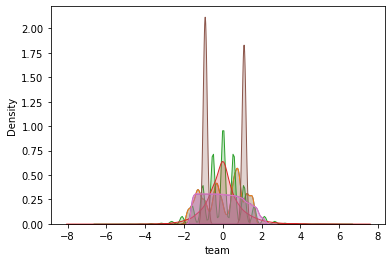

In [22]:

#normalize with Standarize
# fit on training data column
scale = StandardScaler().fit(features)
    
# transform the training data column
scaled_df= scale.transform(features)
featuresNorm= pd.DataFrame(scaled_df, columns= feature_cols)
featuresNorm.head()


for col in features:
    sns.kdeplot(featuresNorm[col], shade=True)
  

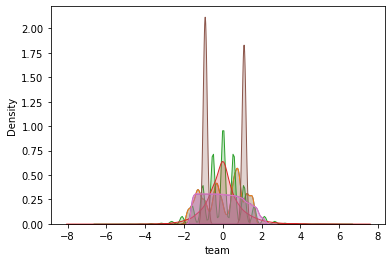

In [21]:
#normalize with Normalize
# fit scaler on training data
scale_2 = MinMaxScaler().fit(features)

# transform training data
scale_df_normalize = scale_2.transform(features)
featureNnorm_norma= pd.DataFrame(scale_df_normalize, columns= feature_cols)
featureNnorm_norma.head()

for col in features:
    sns.kdeplot(featuresNorm[col], shade=True)

In [23]:
target = df1.result

X_train, X_test, y_train, y_test = train_test_split(featuresNorm, target, test_size=0.25 , stratify= target, random_state = 0)

print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)

(71639, 7) (23880, 7) (71639,) (23880,)


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, roc_auc_score, classification_report, log_loss

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

names = ["Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X_train,X_test,y_train,y_test = train_test_split(featuresNorm, target, test_size=0.2, stratify = target)
for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)

        # prediction_proba = clf.predict_proba(X_test)
        # logloss = log_loss(y_test,prediction_proba)
        # precision, recall, fscore, support = score(y_test, prediction)
        # conf_martrix = confusion_matrix(y_test, prediction)
        # clas_report = classification_report(y_test, prediction)

        print(name, accuracy)


Nearest Neighbors 0.9937185929648241
Logistic Regression 1.0
Linear SVM 1.0


In [24]:
svcClassifier = SVC(random_state=100, kernel='rbf')
lr_classifier = LogisticRegression(multi_class='auto', max_iter=1000)
nbClassifier = GaussianNB()
dtClassifier = DecisionTreeClassifier()
rfClassifier = RandomForestClassifier() 


In [25]:
#plot our results
def confusion_matrix(trained_model, y_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)

In [26]:
def model_training(model,X_train, y_train):    
    """
    This function trains a generical model. 
    """
    start = time()
    model.fit(X_train, y_train)
    end = time()
    print("Model trained in {:2f} seconds".format(end-start))

In [27]:
def performance(fited_model,X_test, y_test):
    """
    This functions will return the accuracy of a given
    fited model.
    """
    start = time()
    y_train_predict = fited_model.predict(X_test)
    acc = np.count_nonzero(y_test==y_train_predict) / len(y_train)
    end = time()
    
    print ("Accuracy of the model: ", acc)
    print("Model predicted in {:2f} seconds".format(end-start))



In [28]:
def main_model(model,X_train,X_test,y_train,y_test):
    model_training(model, X_train, y_train) 
    performance(model, X_test, y_test)
    confusion_matrix(model, y_test)
    ROC_PRC_matrix(model, y_test)
    


Logistic Regression one vs All Classifier
--------------------
Model trained in 2.167506 seconds
Accuracy of the model:  0.33333798629238265
Model predicted in 0.010265 seconds


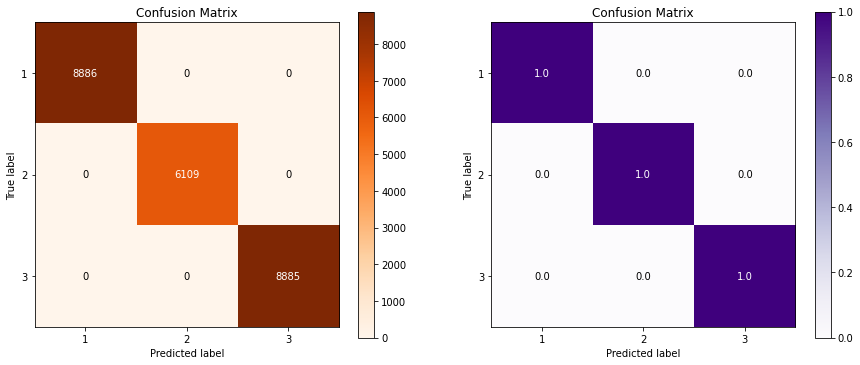

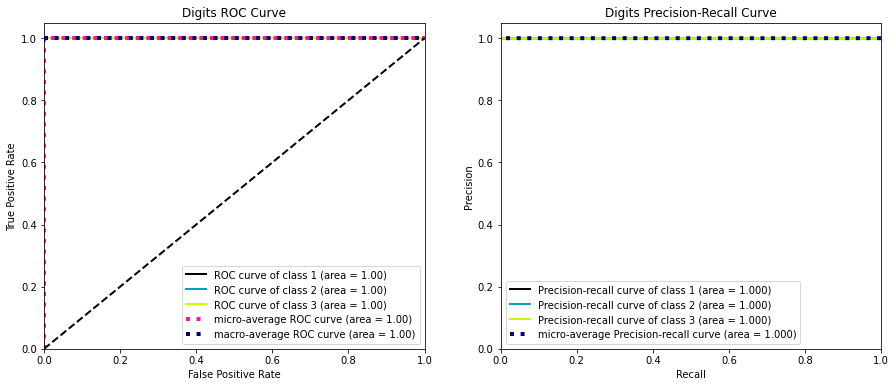

In [29]:
print("Logistic Regression one vs All Classifier")
print("-" * 20)
main_model(lr_classifier,X_train,X_test,y_train,y_test)

In [30]:
print("Gaussain Naive Bayes Classifier")
print("-" * 20)
model_training(nbClassifier, X_train, y_train) 
performance(nbClassifier, X_test, y_test)

Gaussain Naive Bayes Classifier
--------------------
Model trained in 0.034860 seconds
Accuracy of the model:  0.3316210444031882
Model predicted in 0.008751 seconds


In [31]:
print()
print("Random Forest Classifier")
print("-" * 20)
model_training(rfClassifier, X_train, y_train) 
performance(rfClassifier, X_test, y_test)



Random Forest Classifier
--------------------
Model trained in 5.223114 seconds
Accuracy of the model:  0.33333798629238265
Model predicted in 0.387787 seconds


In [33]:
print()
print("Suported Vector Machine Classifier")
print("-" * 20)
model_training(svcClassifier, X_train, y_train) 
performance(svcClassifier, X_test, y_test)


Suported Vector Machine Classifier
--------------------


Feature: 0, Score: 0.00010
Feature: 1, Score: -0.00004
Feature: 2, Score: -14.01015
Feature: 3, Score: 0.03207


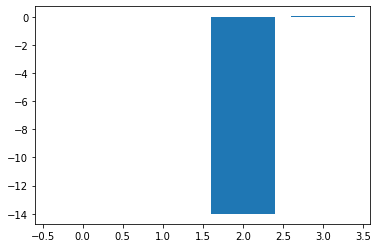

In [101]:
# get importance

models = [lr_classifier]
  
for model in models: 
	importance = model.coef_[0]
	#summarize feature importance
	for i,v in enumerate(importance):
		print('Feature: %0d, Score: %.5f' % (i,v))
	# plot feature importance
	pyplot.bar([x for x in range(len(importance))], importance)
	pyplot.show()

In [108]:
lr_classifier.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

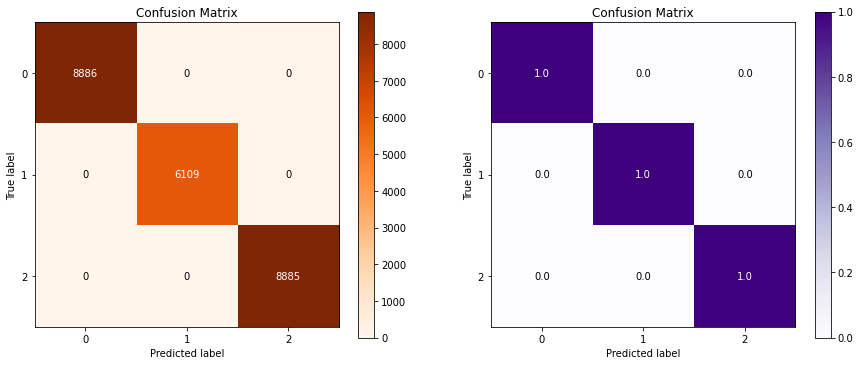

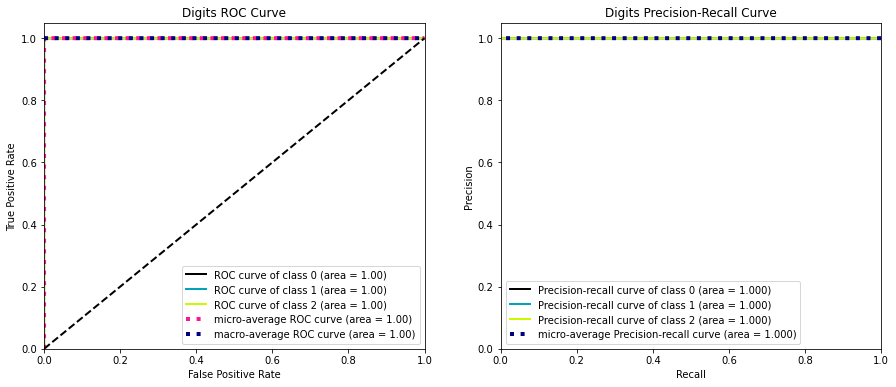

In [118]:

#The first metric that we'll plot is a confusion matrix. 
#The confusion matrix let us analyze how our classification algorithm is doing for various classes of data.



confusion_matrix(lr_classifier,y_test)
ROC_PRC_matrix(lr_classifier, y_test)



<AxesSubplot:title={'center':'Digits ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

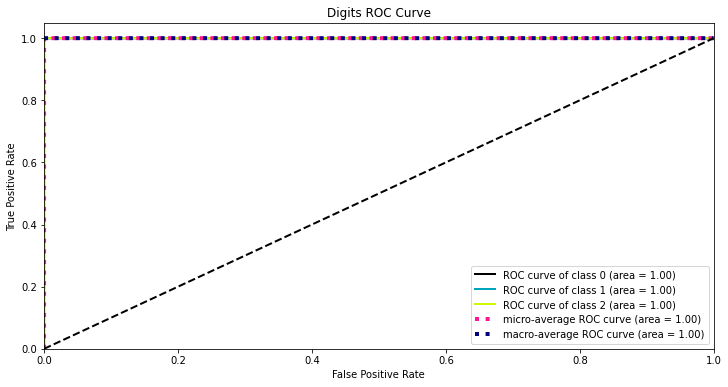

In [105]:

y_test_probs = lr_classifier.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6))

<AxesSubplot:title={'center':'Digits Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

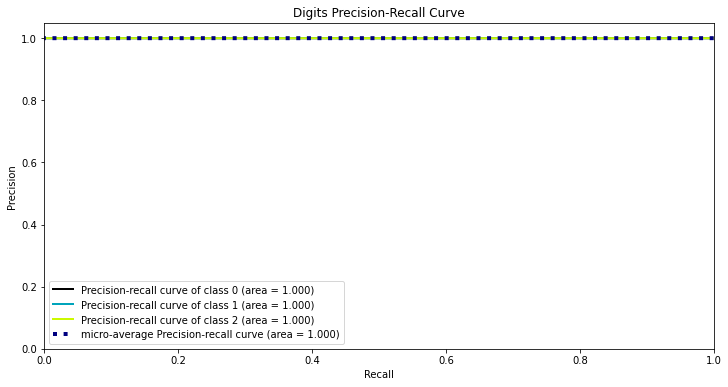

In [115]:
skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                       title="Digits Precision-Recall Curve", figsize=(12,6))